# =================== Desafio Lighthouse ==========================

In [49]:
#!pip install -U scikit-learn
#!pip install Boruta

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import unicodedata
import math
import pickle
from IPython.core.display  import HTML
#from summarytools import dfSummary
from matplotlib import pyplot as plt
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing as pp
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

from boruta import BorutaPy
from scipy.stats import expon, randint

import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.rcParams['figure.figsize'] = [25, 15]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set_theme(style="darkgrid", palette='hls')
    # sns.color_palette("crest", as_cmap=True)
    # sns.color_palette("magma", as_cmap=True)
    # sns.color_palette("flare", as_cmap=True)
    # Increase chart size for better readability
    #sns.set(rc={'figure.figsize':(11,6)})

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
cars_train_raw = pd.read_csv( 'data/cars_train.csv', encoding='utf-16',  delimiter='\t')

# 1.0. Data Description

In [4]:
df1 = cars_train_raw.copy()

In [5]:
df1.sample(5)

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco
17020,206290381713756814553727129949813314349,8.0,CHEVROLET,ONIX,1.0 FLEX PLUS LT MANUAL,2020,2020.0,28941.0,Manual,4,Sedã,N,Branco,PF,São José do Rio Preto,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,Único dono,NaN,IPVA pago,Licenciado,NaN,NaN,NaN,76812.020343
9294,296808795539258594150322518451502707801,8.0,TOYOTA,HILUX SW4,2.8 SRX DIAMOND 4X4 7 LUGARES 16V TURBO INTERC...,2019,2019.0,26040.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,False,False,False,NaN,Único dono,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN,233626.320007
18086,148892562850808890074140741970369846126,8.0,TOYOTA,HILUX,2.8 GR SPORT 4X4 CD 16V DIESEL 4P AUTOMÁTICO,2019,2020.0,32253.0,Automática,4,Picape,N,Branco,PF,Rio de Janeiro,Alagoas (AL),Pessoa Física,False,False,False,NaN,Único dono,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN,345006.894744
9883,183945065302346036579792565046259231481,8.0,AUDI,Q3,2.0 TFSI AMBIENTE QUATTRO 4P GASOLINA S TRONIC,2014,2014.0,57165.0,Automática,4,Sedã,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN,113327.601739
2104,213365110998912618781539731943434026193,16.0,HYUNDAI,ELANTRA,2.0 16V FLEX 4P AUTOMÁTICO,2017,2018.0,64918.0,Automática,4,Sedã,N,Branco,PJ,Rio de Janeiro,Rio de Janeiro (RJ),Loja,True,True,False,Aceita troca,Único dono,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,NaN,NaN,110819.615234


## 1.1 Rename Columns

In [6]:
df1.columns = [unicodedata.normalize('NFKD', col).encode('ASCII', 'ignore').decode('utf-8') for col in df1.columns]

## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 29584
Number of Cols: 29


## 1.3 Data Types

In [8]:
df1.dtypes

id                          object
num_fotos                  float64
marca                       object
modelo                      object
versao                      object
ano_de_fabricacao            int64
ano_modelo                 float64
hodometro                  float64
cambio                      object
num_portas                   int64
tipo                        object
blindado                    object
cor                         object
tipo_vendedor               object
cidade_vendedor             object
estado_vendedor             object
anunciante                  object
entrega_delivery              bool
troca                         bool
elegivel_revisao              bool
dono_aceita_troca           object
veiculo_unico_dono          object
revisoes_concessionaria     object
ipva_pago                   object
veiculo_licenciado          object
garantia_de_fabrica         object
revisoes_dentro_agenda      object
veiculo_alienado           float64
preco               

## 1.4 Check NA

In [9]:
df1.isna().sum()

id                             0
num_fotos                    177
marca                          0
modelo                         0
versao                         0
ano_de_fabricacao              0
ano_modelo                     0
hodometro                      0
cambio                         0
num_portas                     0
tipo                           0
blindado                       0
cor                            0
tipo_vendedor                  0
cidade_vendedor                0
estado_vendedor                0
anunciante                     0
entrega_delivery               0
troca                          0
elegivel_revisao               0
dono_aceita_troca           7662
veiculo_unico_dono         19161
revisoes_concessionaria    20412
ipva_pago                   9925
veiculo_licenciado         13678
garantia_de_fabrica        25219
revisoes_dentro_agenda     23674
veiculo_alienado           29584
preco                          0
dtype: int64

In [10]:
df1.duplicated().sum()

0

## 1.5 Fillout NA

In [11]:
# A coluna 'veiculo_alienado' está com todas as linhas vazias então será removida
df1 = df1.drop(['veiculo_alienado'], axis=1)

# Na coluna 'num_fotos' assumo que os dados com valores vazios não tem fotos, substituindo por 0.
df1['num_fotos'] = df1['num_fotos'].apply( lambda x: 0 if math.isnan(x) else x )

# Nas colunas ['dono_aceita_troca', 'veiculo_unico_dono', 'revisoes_concessionaria', 'ipva_pago', 'veiculo_licenciado', 'garantia_de_fabrica', 'revisoes_dentro_agenda'] conisdero que as linhas com valores vazios significa 'Não' e serão substituidas por 0 e as linhas que tem informação significam 'Sim' e serão substituidas por 1.
df1['dono_aceita_troca'] = df1['dono_aceita_troca'].apply( lambda x: 0 if pd.isna(x) else 1 )
df1['veiculo_unico_dono'] = df1['veiculo_unico_dono'].apply( lambda x: 0 if pd.isna(x) else 1 )
df1['revisoes_concessionaria'] = df1['revisoes_concessionaria'].apply( lambda x: 0 if pd.isna(x) else 1 )
df1['ipva_pago'] = df1['ipva_pago'].apply( lambda x: 0 if pd.isna(x) else 1 )
df1['veiculo_licenciado'] = df1['veiculo_licenciado'].apply( lambda x: 0 if pd.isna(x) else 1 )
df1['garantia_de_fabrica'] = df1['garantia_de_fabrica'].apply( lambda x: 0 if pd.isna(x) else 1 )
df1['revisoes_dentro_agenda'] = df1['revisoes_dentro_agenda'].apply( lambda x: 0 if pd.isna(x) else 1 )

In [12]:
df1.isna().sum()

id                         0
num_fotos                  0
marca                      0
modelo                     0
versao                     0
ano_de_fabricacao          0
ano_modelo                 0
hodometro                  0
cambio                     0
num_portas                 0
tipo                       0
blindado                   0
cor                        0
tipo_vendedor              0
cidade_vendedor            0
estado_vendedor            0
anunciante                 0
entrega_delivery           0
troca                      0
elegivel_revisao           0
dono_aceita_troca          0
veiculo_unico_dono         0
revisoes_concessionaria    0
ipva_pago                  0
veiculo_licenciado         0
garantia_de_fabrica        0
revisoes_dentro_agenda     0
preco                      0
dtype: int64

## 1.6 Change Types

In [13]:
df1['num_fotos'] = df1['num_fotos'].astype( 'int64' )
df1['ano_modelo'] = df1['ano_modelo'].astype( 'int64' )

In [14]:
df1.dtypes

id                          object
num_fotos                    int64
marca                       object
modelo                      object
versao                      object
ano_de_fabricacao            int64
ano_modelo                   int64
hodometro                  float64
cambio                      object
num_portas                   int64
tipo                        object
blindado                    object
cor                         object
tipo_vendedor               object
cidade_vendedor             object
estado_vendedor             object
anunciante                  object
entrega_delivery              bool
troca                         bool
elegivel_revisao              bool
dono_aceita_troca            int64
veiculo_unico_dono           int64
revisoes_concessionaria      int64
ipva_pago                    int64
veiculo_licenciado           int64
garantia_de_fabrica          int64
revisoes_dentro_agenda       int64
preco                      float64
dtype: object

## 1.7 Descriptive Statistical

In [ ]:
Média, Moda e mediana passam a ideia de dispersão
Podem mostrar que os dados tem uma assimetria a esquerda, ou que tem uma dispersão simétrica ou ainda que tem uma assimetria a direita

### Numerical Attributes

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [16]:
cat_attributes.columns

Index(['id', 'marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'anunciante',
       'entrega_delivery', 'troca', 'elegivel_revisao'],
      dtype='object')

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispercion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T.astype(int)
d3 = pd.DataFrame( num_attributes.apply( max ) ).T.astype(int)
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T.astype(int)
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.0,21.0,21.0,10.262067,8.000000,3.566818,0.837134,-0.390327
1,ano_de_fabricacao,1985.0,2022.0,37.0,2016.758552,2018.000000,4.062353,-2.493793,9.189095
2,ano_modelo,1997.0,2023.0,26.0,2017.808985,2018.000000,2.673885,-0.498640,-0.522504
3,hodometro,100.0,390065.0,389965.0,58430.592077,57434.000000,32561.218977,0.590908,1.194606
4,num_portas,2.0,4.0,2.0,3.940677,4.000000,0.338355,-5.544991,28.797600
5,dono_aceita_troca,0.0,1.0,1.0,0.741009,1.000000,0.438081,-1.100349,-0.789286
6,veiculo_unico_dono,0.0,1.0,1.0,0.352319,0.000000,0.477693,0.618342,-1.617763
7,revisoes_concessionaria,0.0,1.0,1.0,0.310032,0.000000,0.462507,0.821511,-1.325209
8,ipva_pago,0.0,1.0,1.0,0.664515,1.000000,0.472160,-0.696895,-1.514440
9,veiculo_licenciado,0.0,1.0,1.0,0.537655,1.000000,0.498580,-0.151059,-1.977315


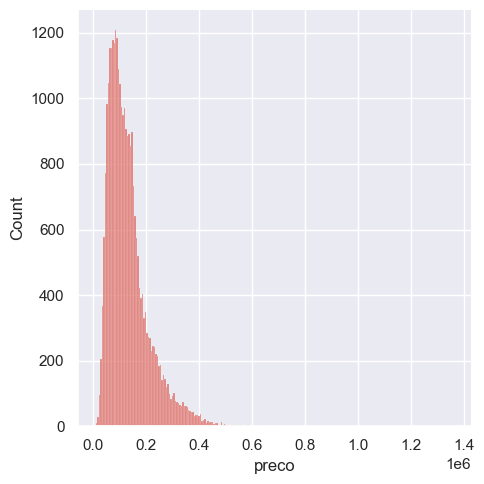

In [18]:
# Check preco attribute distribution
sns.displot( df1['preco'], kde=False );

#### Numerical Attributes Analysis
* `ano_de_fabricacao` e `ano_modelo`: O menor ano de fabricação é 1985 e o menor ano do modelo é 1997. Precisa ser investigado.


### Categorical Attributes

In [19]:
df1.describe(exclude=np.number).T

,count,unique,top,freq
id,29584,29584,300716223898539419613863097469899222392,1
marca,29584,40,VOLKSWAGEN,4594
modelo,29584,457,COMPASS,1480
versao,29584,1916,1.6 16V FLEX ALLURE PACK 4P AUTOMÁTICO,1352
cambio,29584,7,Automática,22545
tipo,29584,7,Sedã,16429
blindado,29584,2,N,29336
cor,29584,7,Branco,20949
tipo_vendedor,29584,2,PF,17926
cidade_vendedor,29584,575,São Paulo,6158


In [20]:
cat_attributes.columns

Index(['id', 'marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'anunciante',
       'entrega_delivery', 'troca', 'elegivel_revisao'],
      dtype='object')

<Axes: xlabel='cor', ylabel='preco'>

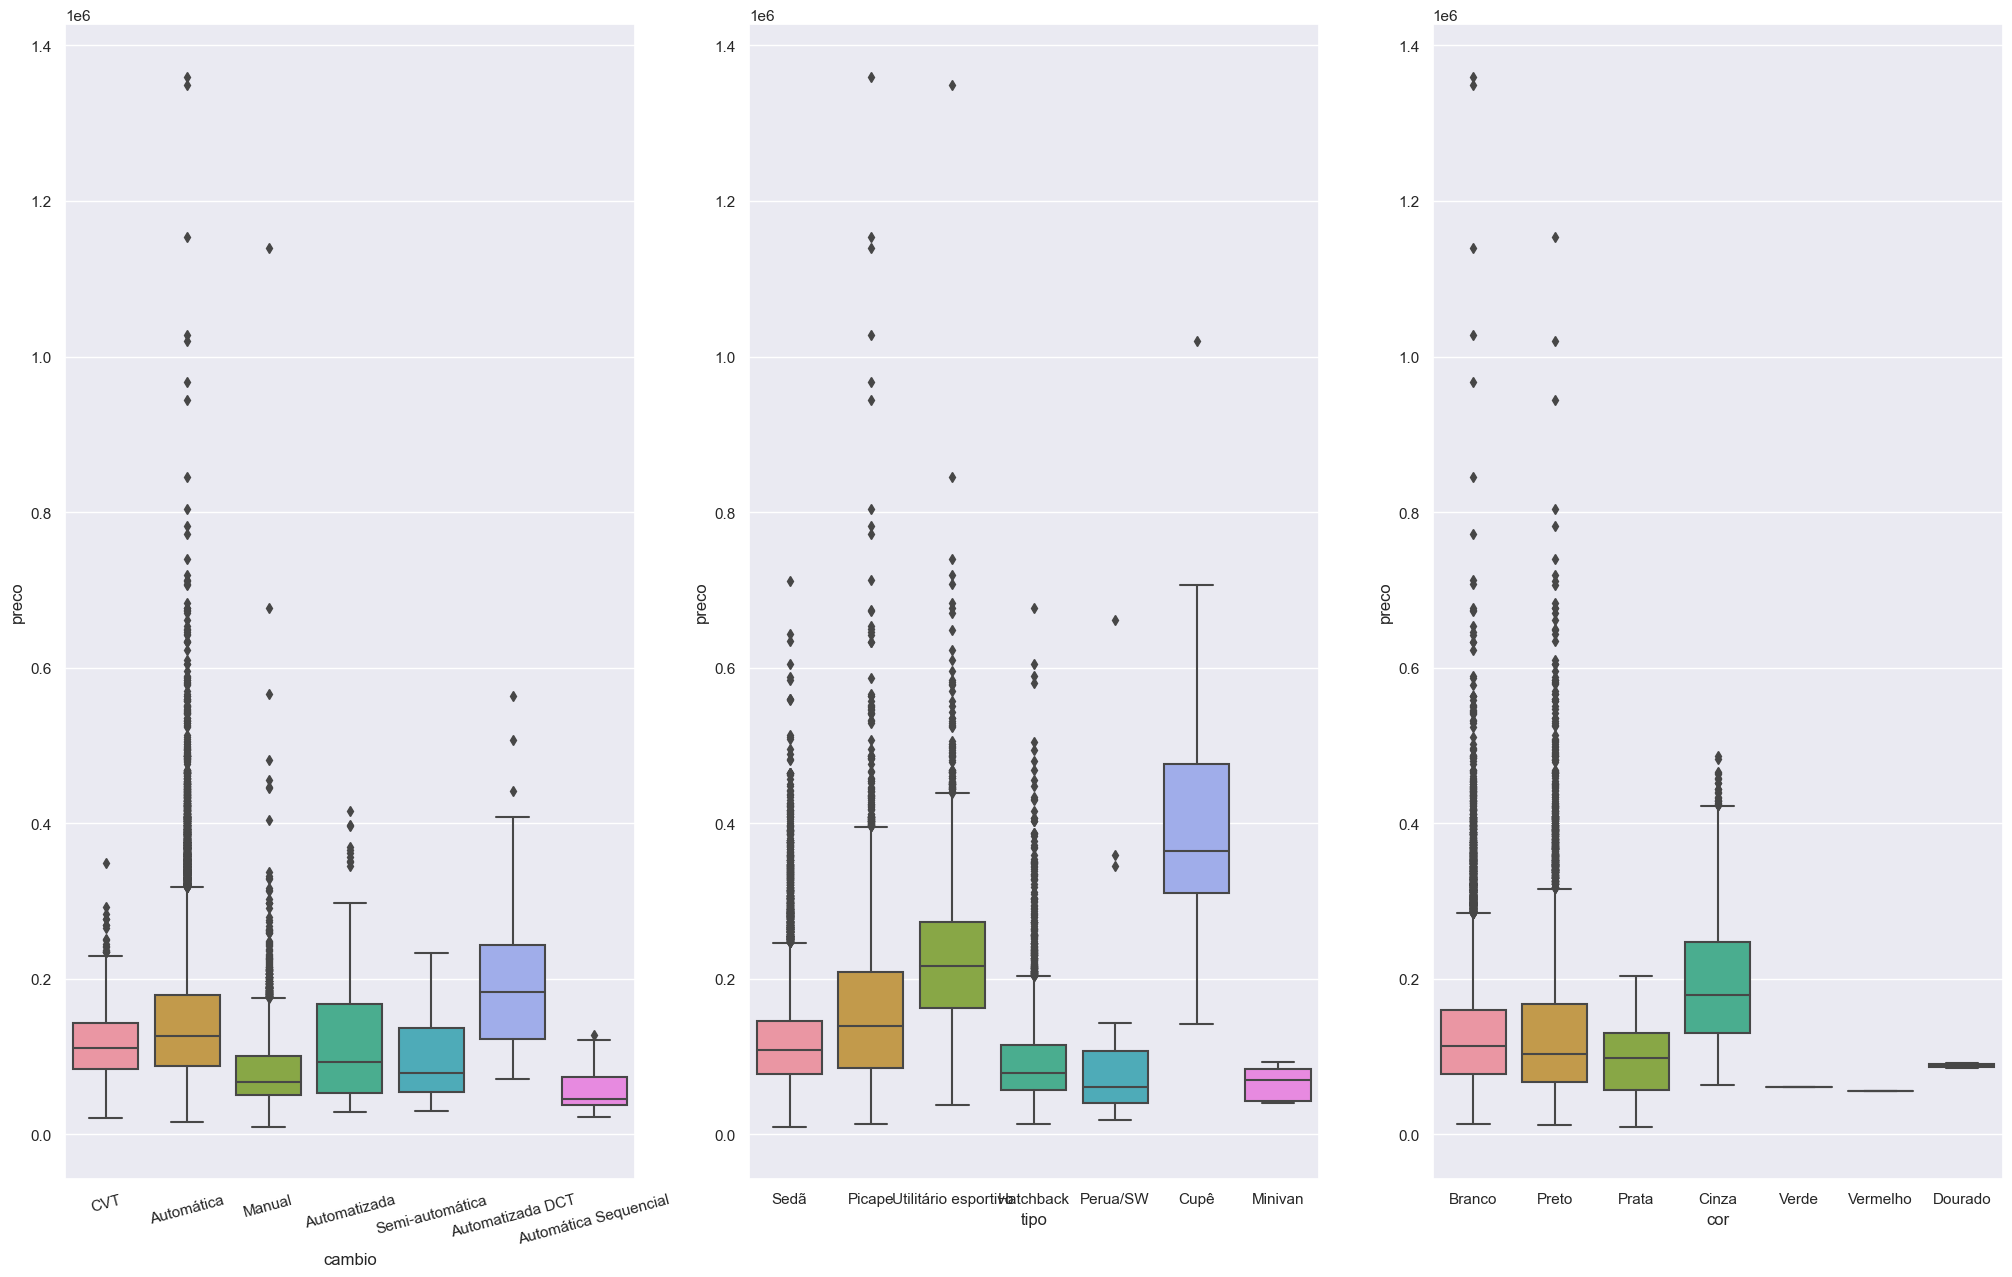

In [22]:
plt.subplot(1, 3, 1)
sns.boxplot( x='cambio', y='preco', data=df1)
plt.xticks(rotation=15);

plt.subplot(1, 3, 2)
sns.boxplot( x='tipo', y='preco', data=df1)

plt.subplot(1, 3, 3)
sns.boxplot( x='cor', y='preco', data=df1)

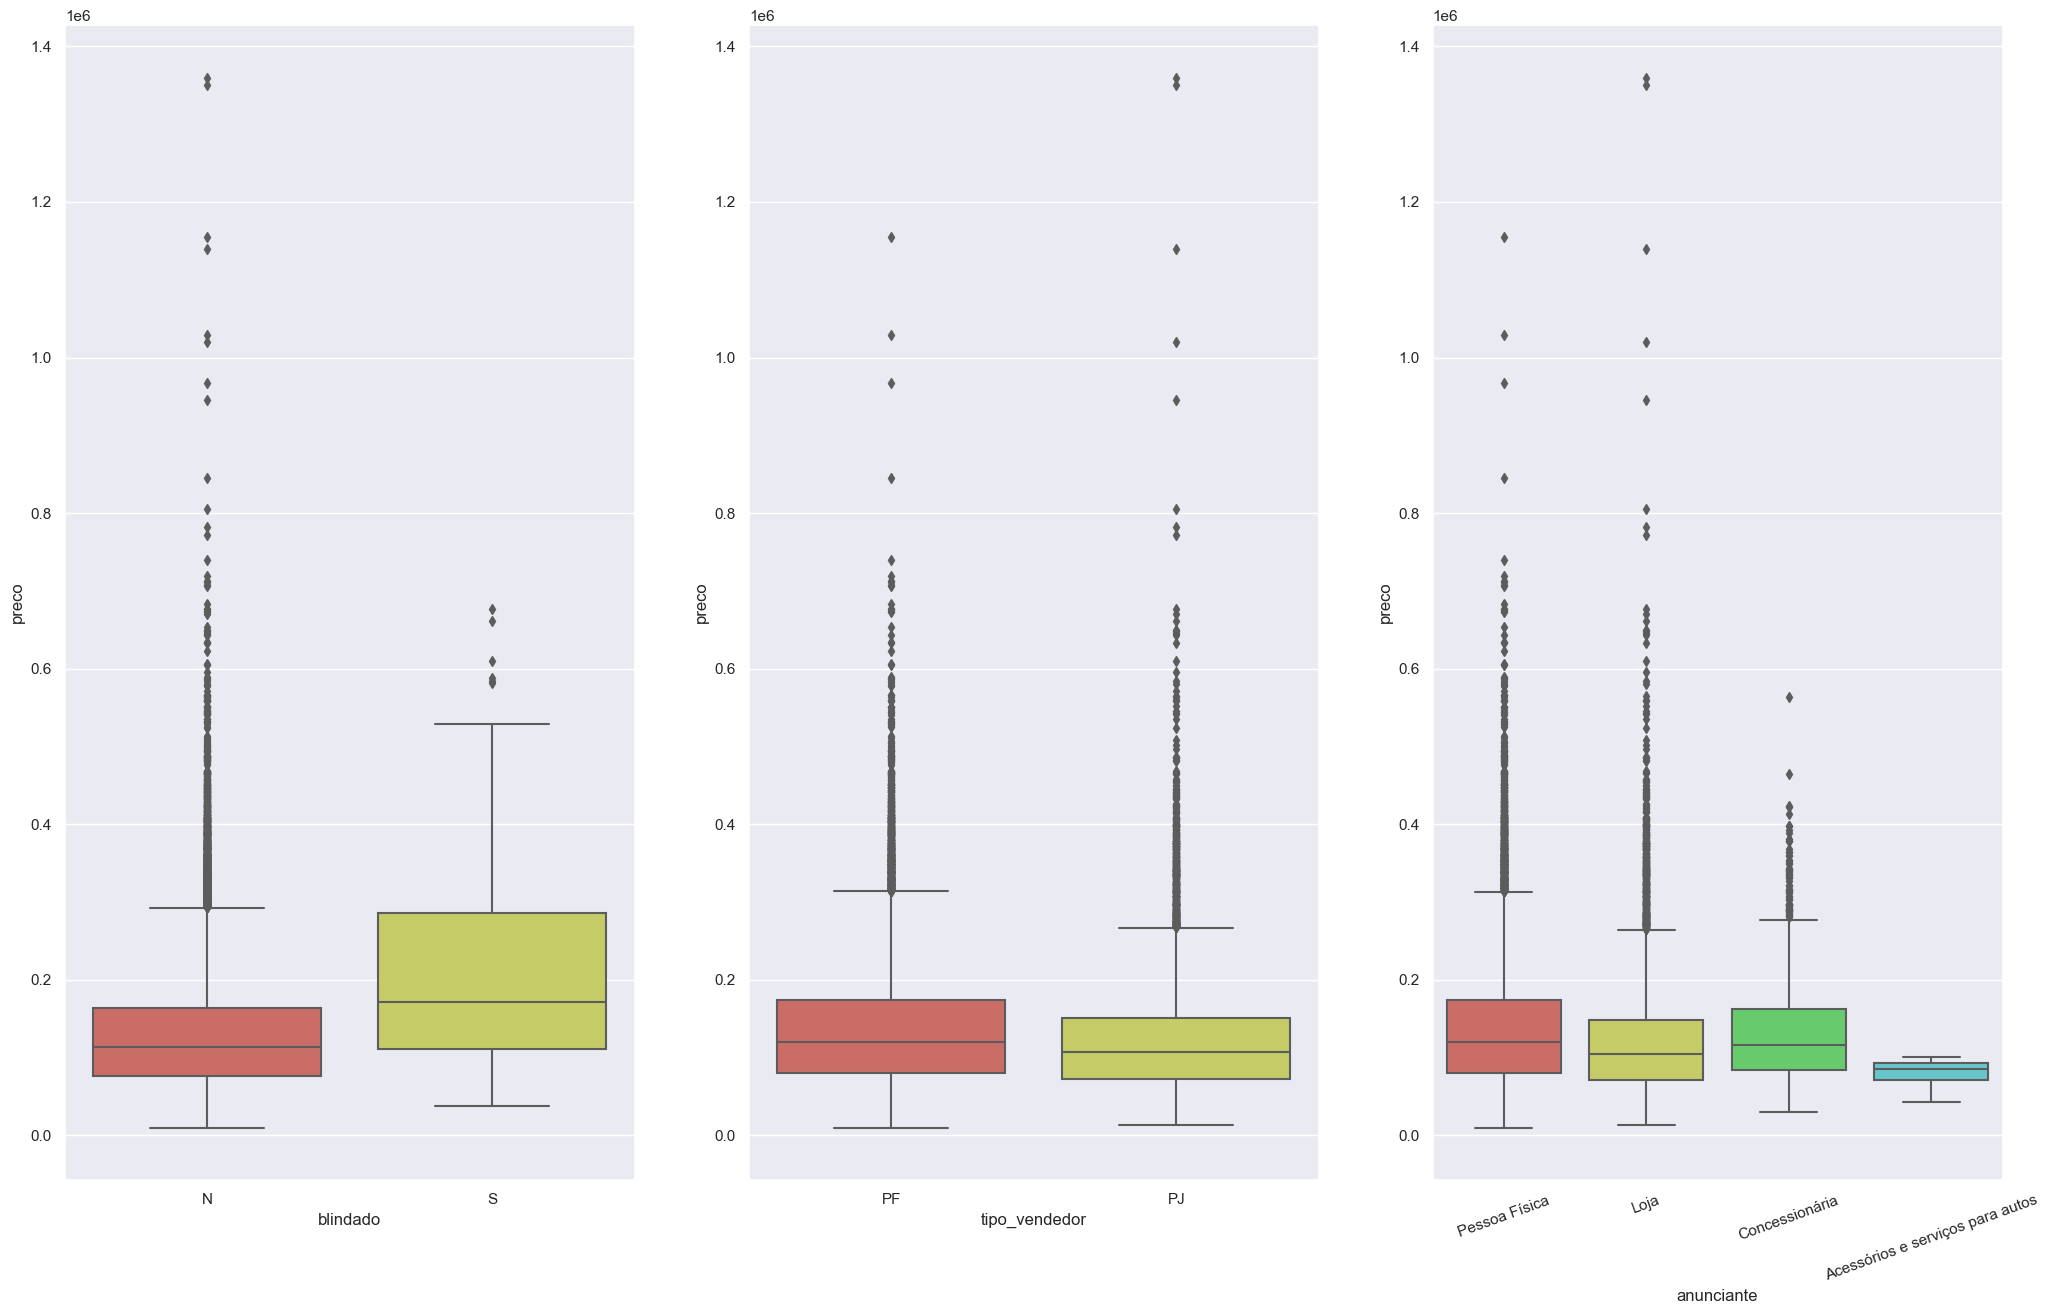

In [23]:
plt.subplot(1, 3, 1)
sns.boxplot( x='blindado', y='preco', data=df1)

plt.subplot(1, 3, 2)
sns.boxplot( x='tipo_vendedor', y='preco', data=df1)

plt.subplot(1, 3, 3)
sns.boxplot( x='anunciante', y='preco', data=df1)
plt.xticks(rotation=20);

<Axes: xlabel='elegivel_revisao', ylabel='preco'>

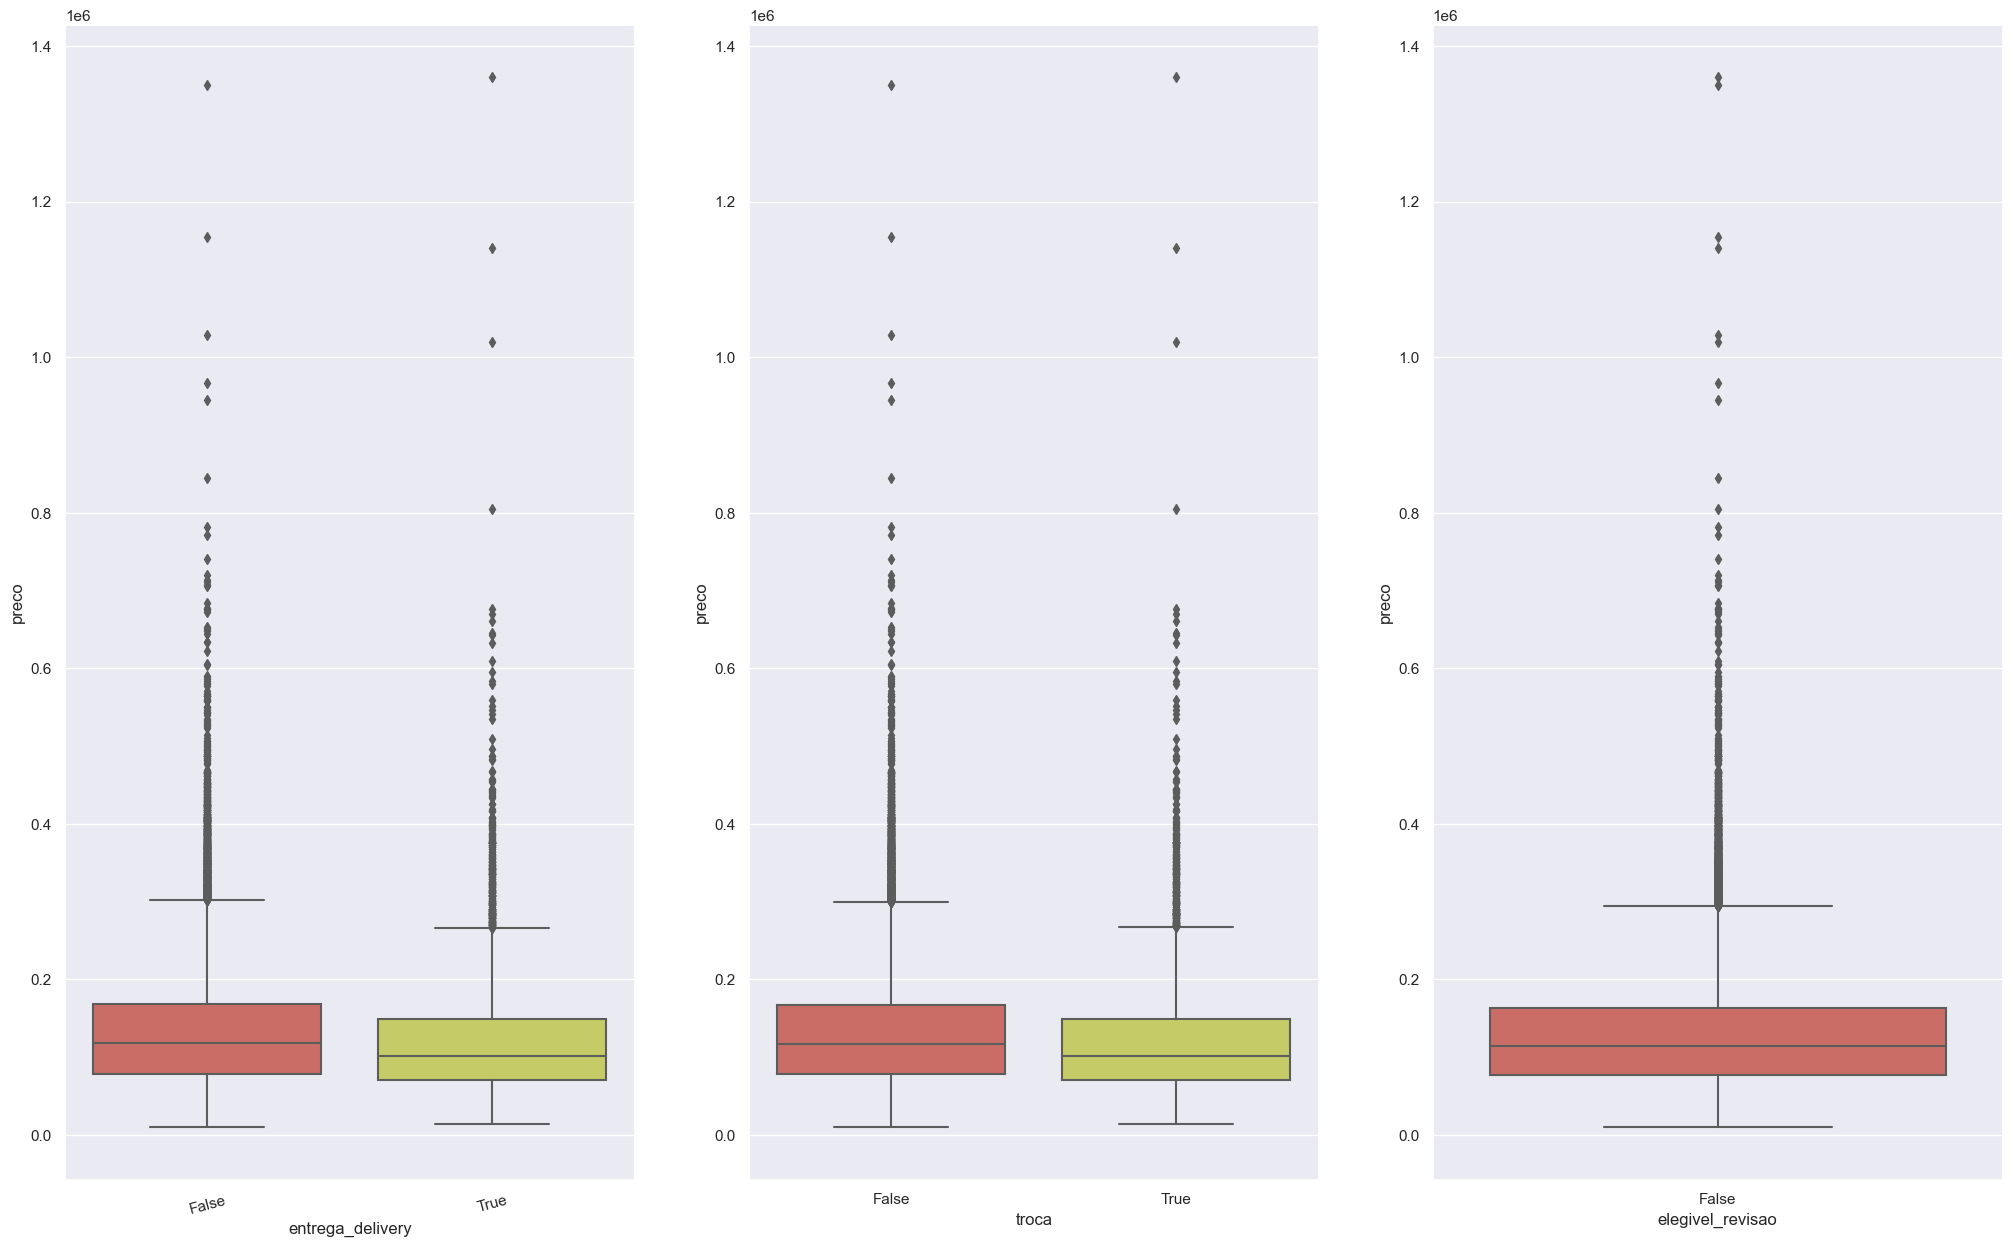

In [24]:
plt.subplot(1, 3, 1)
sns.boxplot( x='entrega_delivery', y='preco', data=df1)
plt.xticks(rotation=15);

plt.subplot(1, 3, 2)
sns.boxplot( x='troca', y='preco', data=df1)

plt.subplot(1, 3, 3)
sns.boxplot( x='elegivel_revisao', y='preco', data=df1)

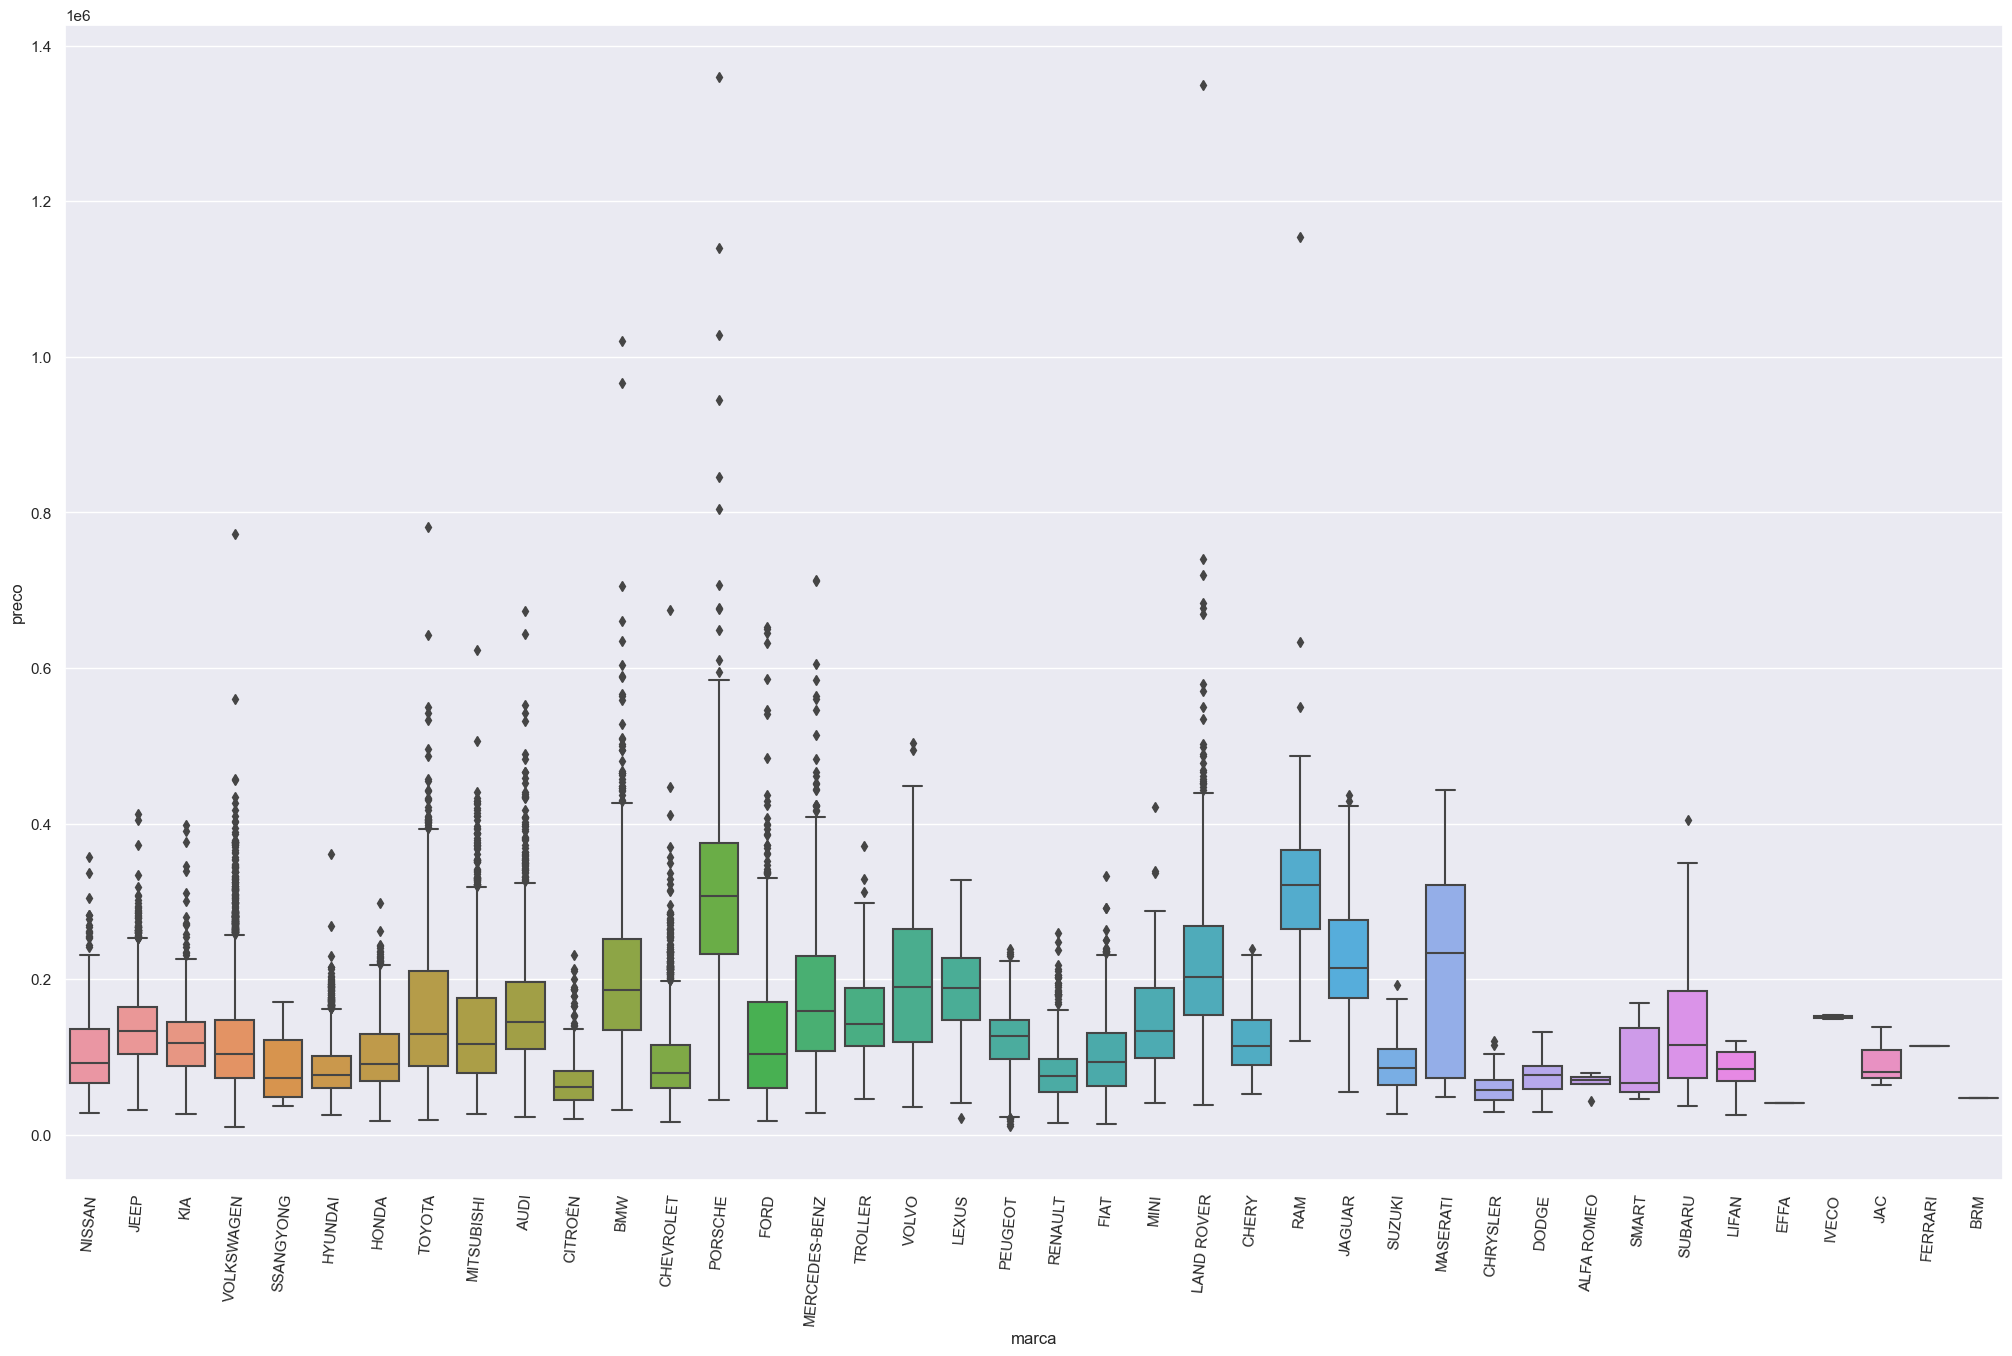

In [25]:
sns.boxplot( x='marca', y='preco', data=df1)
plt.xticks(rotation=85);

In [26]:
df1['cor'].value_counts(normalize=True)

Branco      0.708119
Preto       0.177664
Prata       0.058849
Cinza       0.055233
Dourado     0.000068
Verde       0.000034
Vermelho    0.000034
Name: cor, dtype: float64

# 2.0. Feature Engineering

In [27]:
df2 = df1.copy()

In [28]:
# Na coluna 'blindado' substitui 'N' por 0 e 'S' por 1
df2['blindado'] = df2['blindado'].apply( lambda x: 0 if x=='N' else 1)

# A coluna 'elegivel_revisao' tem todos as linhas como False e por isso será excluida.
df2 = df2.drop(['elegivel_revisao'], axis=1)

# Nas colunas 'entrega_delivery' e 'troca' substitui False por 0 e True por 1
df2['entrega_delivery'] = df2['entrega_delivery'].apply( lambda x: 0 if x==False else 1)
df2['troca'] = df2['troca'].apply( lambda x: 0 if x==False else 1)

In [29]:
df2.sample(2).T

,4955,13127
id,108596761982119886558431079947495348224,338277491202055019171089893862131836558
num_fotos,8,8
marca,HYUNDAI,HYUNDAI
modelo,HB20S,CRETA
versao,1.6 COMFORT STYLE 16V FLEX 4P AUTOMÁTICO,1.6 16V FLEX ACTION AUTOMÁTICO
ano_de_fabricacao,2019,2021
ano_modelo,2019,2021
hodometro,28249.0,10537.0
cambio,Automática,Automática
num_portas,4,4


## 2.1. Hypothesis

1. Hipótese 1: Os modelos mais vendidos também são os que tem menor média de preço
2. Hipótese 2: Carros com transmissão automática têm preços mais altos nas Capitais
3. Hipótese 3: Carros vendidos por anunciantes profissionais têm preços mais altos do que carros vendidos por pessoa física.


### Hipótese 1: Os modelos com mais oferta de carros também são os que tem menor média de preço
**Hipótese Falsa** Como visto no gráfico abaixo, os preços dos modelos não tem correlação com a quantidade de ofertas.

In [30]:
df_aux = df2[['modelo', 'preco', 'id']].groupby('modelo').agg({'preco': 'mean', 'id': 'count'}).sort_values('preco', ascending=True).reset_index()
df_aux = df_aux[df_aux['id']>1]

In [31]:
df_preco = df2[['modelo', 'preco']].groupby('modelo').mean().sort_values('preco', ascending=True ).reset_index()
df_preco

,modelo,preco
0,PASEO,18528.457166
1,SYMBOL,18763.904063
2,ESCORT,20161.917961
3,ES,21815.216211
4,STILO,23276.853636
5,SANTANA,24146.950045
6,530,25195.990696
7,COURIER,27416.670303
8,SIENA,30905.751642
9,ASTRA,31855.230504


In [32]:
df_oferta = df2[['modelo', 'id']].groupby('modelo').count().sort_values('id', ascending=False ).reset_index()
df_oferta

,modelo,id
0,COMPASS,1480
1,2008,1431
2,Q3,914
3,TORO,902
4,COROLLA,867
5,ONIX,855
6,320i,822
7,AMAROK,725
8,GOLF,697
9,HILUX,648


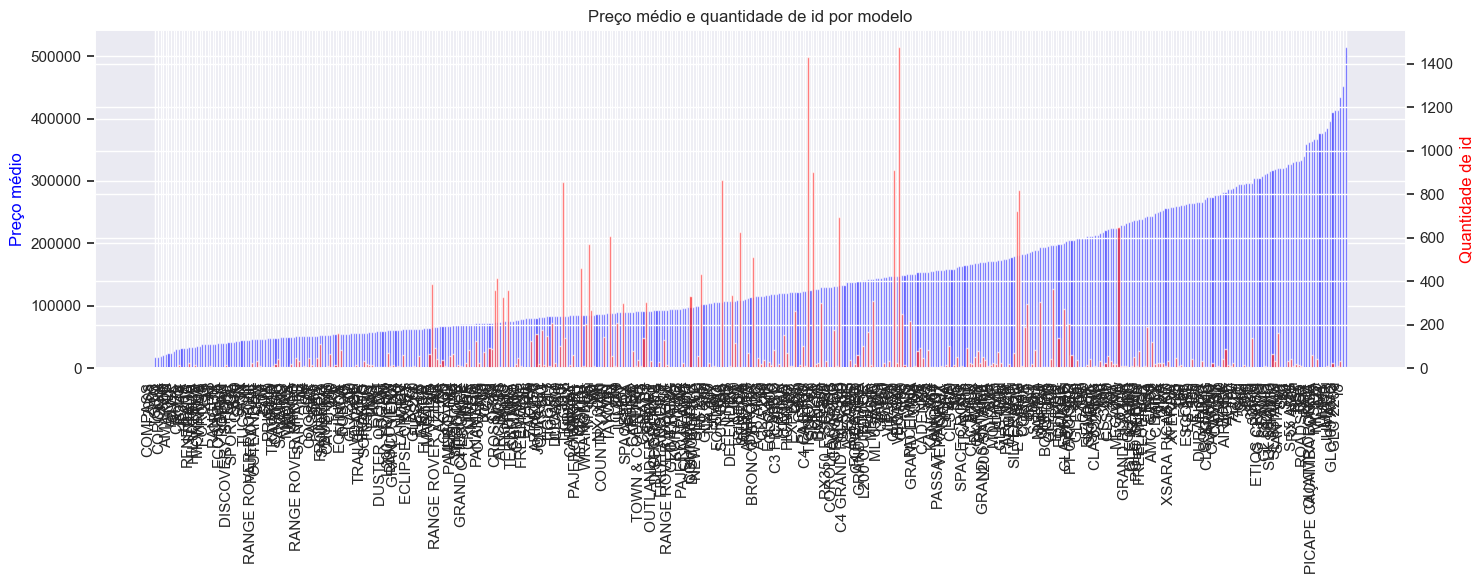

In [33]:
# Cria o gráfico com duas escalas y
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

# Preço médio (eixo y esquerdo)
ax1.bar(df_preco['modelo'], df_preco['preco'], color='b', alpha=0.7)
ax1.set_ylabel('Preço médio', color='b')

# Quantidade de 'id' (eixo y direito)
ax2.bar(df_oferta['modelo'], df_oferta['id'], color='r', alpha=0.7)
ax2.set_ylabel('Quantidade de id', color='r')

ax1.set_xticklabels(df_preco['modelo'], rotation=90, ha='right')
ax2.set_xticklabels(df_oferta['modelo'], rotation=90, ha='left')
plt.title('Preço médio e quantidade de id por modelo')
plt.tight_layout()
plt.show()



### Hipótese 2: Carros com transmissão automática têm preços mais altos nas Capitais
**Falso** A média de preço em outras cidades é maior que nas capitais

In [34]:
df_cambio_auto = df2.loc[(df2['cambio'] == 'Automática'), :]

In [35]:
capitais_brasil = ["Rio Branco","Maceió","Macapá","Manaus","Salvador","Fortaleza","Brasília","Vitória","Goiânia","São Luís","Cuiabá","Campo Grande","Belo Horizonte","Belém","João Pessoa","Curitiba","Recife","Teresina","Rio de Janeiro","Natal","Porto Alegre","Porto Velho","Boa Vista","Florianópolis","São Paulo","Aracaju","Palmas"]

df_capitais = df_cambio_auto[df_cambio_auto['cidade_vendedor'].isin(capitais_brasil)]
df_nao_capitais = df_cambio_auto[~df_cambio_auto['cidade_vendedor'].isin(capitais_brasil)]

print('Média de preço de carros com transmissão automática em Capitais {:.2f}'.format(df_capitais.preco.mean()))
print('Média de preço de carros com transmissão automática em outras cidades {:.2f}'.format(df_nao_capitais.preco.mean()))

Média de preço de carros com transmissão automática em Capitais 145118.27
Média de preço de carros com transmissão automática em outras cidades 147782.63


In [36]:
df_capitais[['cidade_vendedor', 'preco']].groupby('cidade_vendedor').mean()

,preco
cidade_vendedor,
Aracaju,253190.926332
Belo Horizonte,150157.172220
Belém,140591.467645
Brasília,155459.691628
Campo Grande,180846.326569
Cuiabá,171235.616229
Curitiba,156485.701813
Florianópolis,151309.018464
Fortaleza,111002.681516


### Hipótese 3: Carros vendidos por anunciantes profissionais têm preços mais altos do que carros vendidos por pessoa física.
**Falso** A média de preço de venda dos carros anunciados por pessoa física é 12,04% maior do que a média de venda dos anunciantes profissionais.

In [37]:
df_anun_pro = df2.loc[(df2['anunciante'] == 'Loja') | (df2['anunciante'] == 'Concessionária'), :]
df_anun_pf = df2.loc[df2['anunciante'] == 'Pessoa Física', :]

print('Média de preço de carros vendidos por Loja e Concessionária: {:.2f}'.format(df_anun_pro.preco.mean()))
print('Média de preço de carros vendidos por Pessoa Física: {:.2f}'.format(df_anun_pf.preco.mean()))


Média de preço de carros vendidos por Loja e Concessionária: 123949.03
Média de preço de carros vendidos por Pessoa Física: 138874.96


### a. Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?

In [39]:
# definir quais são as marcas populares
df2[['marca', 'preco', 'id']].groupby([ 'marca']).agg({'id': 'count', 'preco': 'mean'}).reset_index().sort_values( 'id', ascending=False )

,marca,id,preco
38,VOLKSWAGEN,4594,117940.087380
5,CHEVROLET,3020,93187.683964
36,TOYOTA,2180,156195.160143
14,HYUNDAI,2043,84419.639625
18,JEEP,2000,138367.166001
11,FIAT,1918,99711.164582
2,BMW,1784,200501.186503
1,AUDI,1698,159977.750342
28,PEUGEOT,1675,122797.835086
13,HONDA,1586,100620.715073


In [40]:
# Marcas populares definidas
marca_popular = ['VOLKSWAGEN', 'CHEVROLET', 'HYUNDAI', 'FIAT']

In [41]:
# Filtrando o dataset apenas com as marcas populares
df_marca_popular = df2.loc[df2['marca'].isin(marca_popular), :]

In [42]:
# transformações de colunas para fazer a tabela
df_marca_popular['tipo_vendedor'] = df_marca_popular['tipo_vendedor'].str.strip()
tipovendedor = {'PJ': 0 , 'PF': 1}
df_marca_popular['tipo_vendedor'] = df_marca_popular['tipo_vendedor'].map( tipovendedor )

In [43]:
aux = df_marca_popular[['dono_aceita_troca', 'estado_vendedor', 'anunciante', 'id', 'tipo_vendedor', 'preco']].groupby('estado_vendedor').agg({'id':'count', 'dono_aceita_troca': 'sum', 'tipo_vendedor': 'sum', 'preco': 'mean'}).reset_index().sort_values('id', ascending=False)
aux['perc_troca'] = round((aux.dono_aceita_troca / aux.id *100), 2)
aux['perc_vendedor_pf'] = round((aux.tipo_vendedor / aux.id *100), 2)
aux.head(10)

,estado_vendedor,id,dono_aceita_troca,tipo_vendedor,preco,perc_troca,perc_vendedor_pf
23,São Paulo (SP),6522,4819,3492,99774.456317,73.89,53.54
18,Rio de Janeiro (RJ),1003,736,506,105093.384962,73.38,50.45
11,Paraná (PR),902,659,455,112368.709135,73.06,50.44
21,Santa Catarina (SC),847,661,399,99840.590068,78.04,47.11
10,Minas Gerais (MG),663,457,369,108069.037520,68.93,55.66
17,Rio Grande do Sul (RS),566,339,375,110617.199854,59.89,66.25
6,Goiás (GO),303,205,192,119892.820649,67.66,63.37
3,Bahia (BA),255,237,124,99310.886251,92.94,48.63
14,Pernambuco (PE),132,123,28,92075.212611,93.18,21.21
12,Paraíba (PB),80,80,5,87533.702297,100.00,6.25


#### Para responder essa pergunta considerei 4 fatores:
* `id`: Calculando a soma de veiculos por estado, que seria a oferta por estado, eu assumi que quanto maior a oferta, mais favorável economicamente a região é para fazer negócio.
* `preco`: Quanto maior a média de preço de um estado, maoir será meu lucro caso eu consiga vender.
* `tipo_vendedor`: Quanto maoir a proporção de vendedores PF em comparação com PJ, menos concorrência de outras lojas eu terei
* `dono_aceita_troca`: Se o vendedor aceita troca, tenho mais alternativas para fazer algum negócio com ele.

O melhor Estado para se vender um carro de marca popular é **Goiás(GO)**. Analisando a tabela acima, conclui: Entre os 10 Estados com mais ofertas, ele é o que tem maior média de preço e é o segundo maior em proporção de vendedores PF, apesar de estar a baixo da média em relação ao vendedor aceitar troca.

### b. Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?

In [44]:
df_picape_auto = df2.loc[(df2['cambio'] == 'Automática') & (df2['tipo'] == 'Picape'), :]

In [45]:
df_picape_auto[['estado_vendedor', 'preco', 'id']].groupby('estado_vendedor').agg({'preco': 'mean', 'id': 'count'}).sort_values('preco', ascending=True)

,preco,id
estado_vendedor,,
Paraíba (PB),93157.035264,4
Mato Grosso do Sul (MS),144700.247621,5
Acre (AC),145256.693656,6
Rio Grande do Norte (RN),179961.694768,1
Rio de Janeiro (RJ),181660.344685,318
Santa Catarina (SC),185848.618546,283
Tocantins (TO),187717.127524,3
São Paulo (SP),188427.484638,1712
Pernambuco (PE),192566.764505,14


In [46]:
df_aux = df_picape_auto.loc[df_picape_auto['garantia_de_fabrica'] == 1 , :]
df_aux[['estado_vendedor', 'preco', 'id']].groupby('estado_vendedor').agg({'preco': 'mean', 'id': 'count'}).sort_values('preco', ascending=True)

,preco,id
estado_vendedor,,
Rio Grande do Norte (RN),179961.694768,1
Mato Grosso (MT),197657.066561,2
Minas Gerais (MG),210890.490416,36
Pernambuco (PE),222166.668612,2
São Paulo (SP),222523.322315,282
Rio Grande do Sul (RS),224316.599327,39
Rio de Janeiro (RJ),227941.875261,57
Acre (AC),228022.077115,1
Alagoas (AL),229622.921633,10


#### Para responder a pergunta considerie 2 fatores:
* `preco`: A melhor escolha é onde o preço é menor.
* `id`: O estado precisa ter uma quantidade minimamente representativa de oferta.
* `garantia_de_fabrica`: Filtrei apenas veículos que tem garantia de fábrica pois isso agrega valor ao veículo. 
    
Analisando a tabela acima já filtrada com veiculos que tem garantia de fábrica, e com os fatores preço e oferta, a conclusão é que o melhor Estado para comprar uma picape com transmissão automática é **Minas Gerais (MG)**

### c. Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

In [47]:
df_aux = df2.loc[df2['garantia_de_fabrica'] == 1, :]

In [48]:
df_aux1 = df_aux[['estado_vendedor', 'preco', 'id']].groupby('estado_vendedor').agg({'preco': 'mean', 'id': 'count'}).sort_values('preco', ascending=True)
df_aux1

,preco,id
estado_vendedor,,
Paraíba (PB),95762.746630,1
Pará (PA),98156.615283,17
Amazonas (AM),99617.303347,9
Espírito Santo (ES),104030.208116,9
Mato Grosso do Sul (MS),121709.589845,13
Ceará (CE),123939.878795,1
Rio Grande do Norte (RN),133120.393894,9
Pernambuco (PE),149898.416932,20
Acre (AC),150416.911346,2


#### Resposta:
* Considerando apenas dados de veiculos que ainda estejam dentro da garantia de fabrica e ordenando pela média de preço por estado como mostra a tabela acima, o Estado que tem um numero de ofertas minimamente aceitavel com menor preço médio e portando o melhor para se comprar é o **Pará (PA)**.

# Multivariate Analysis

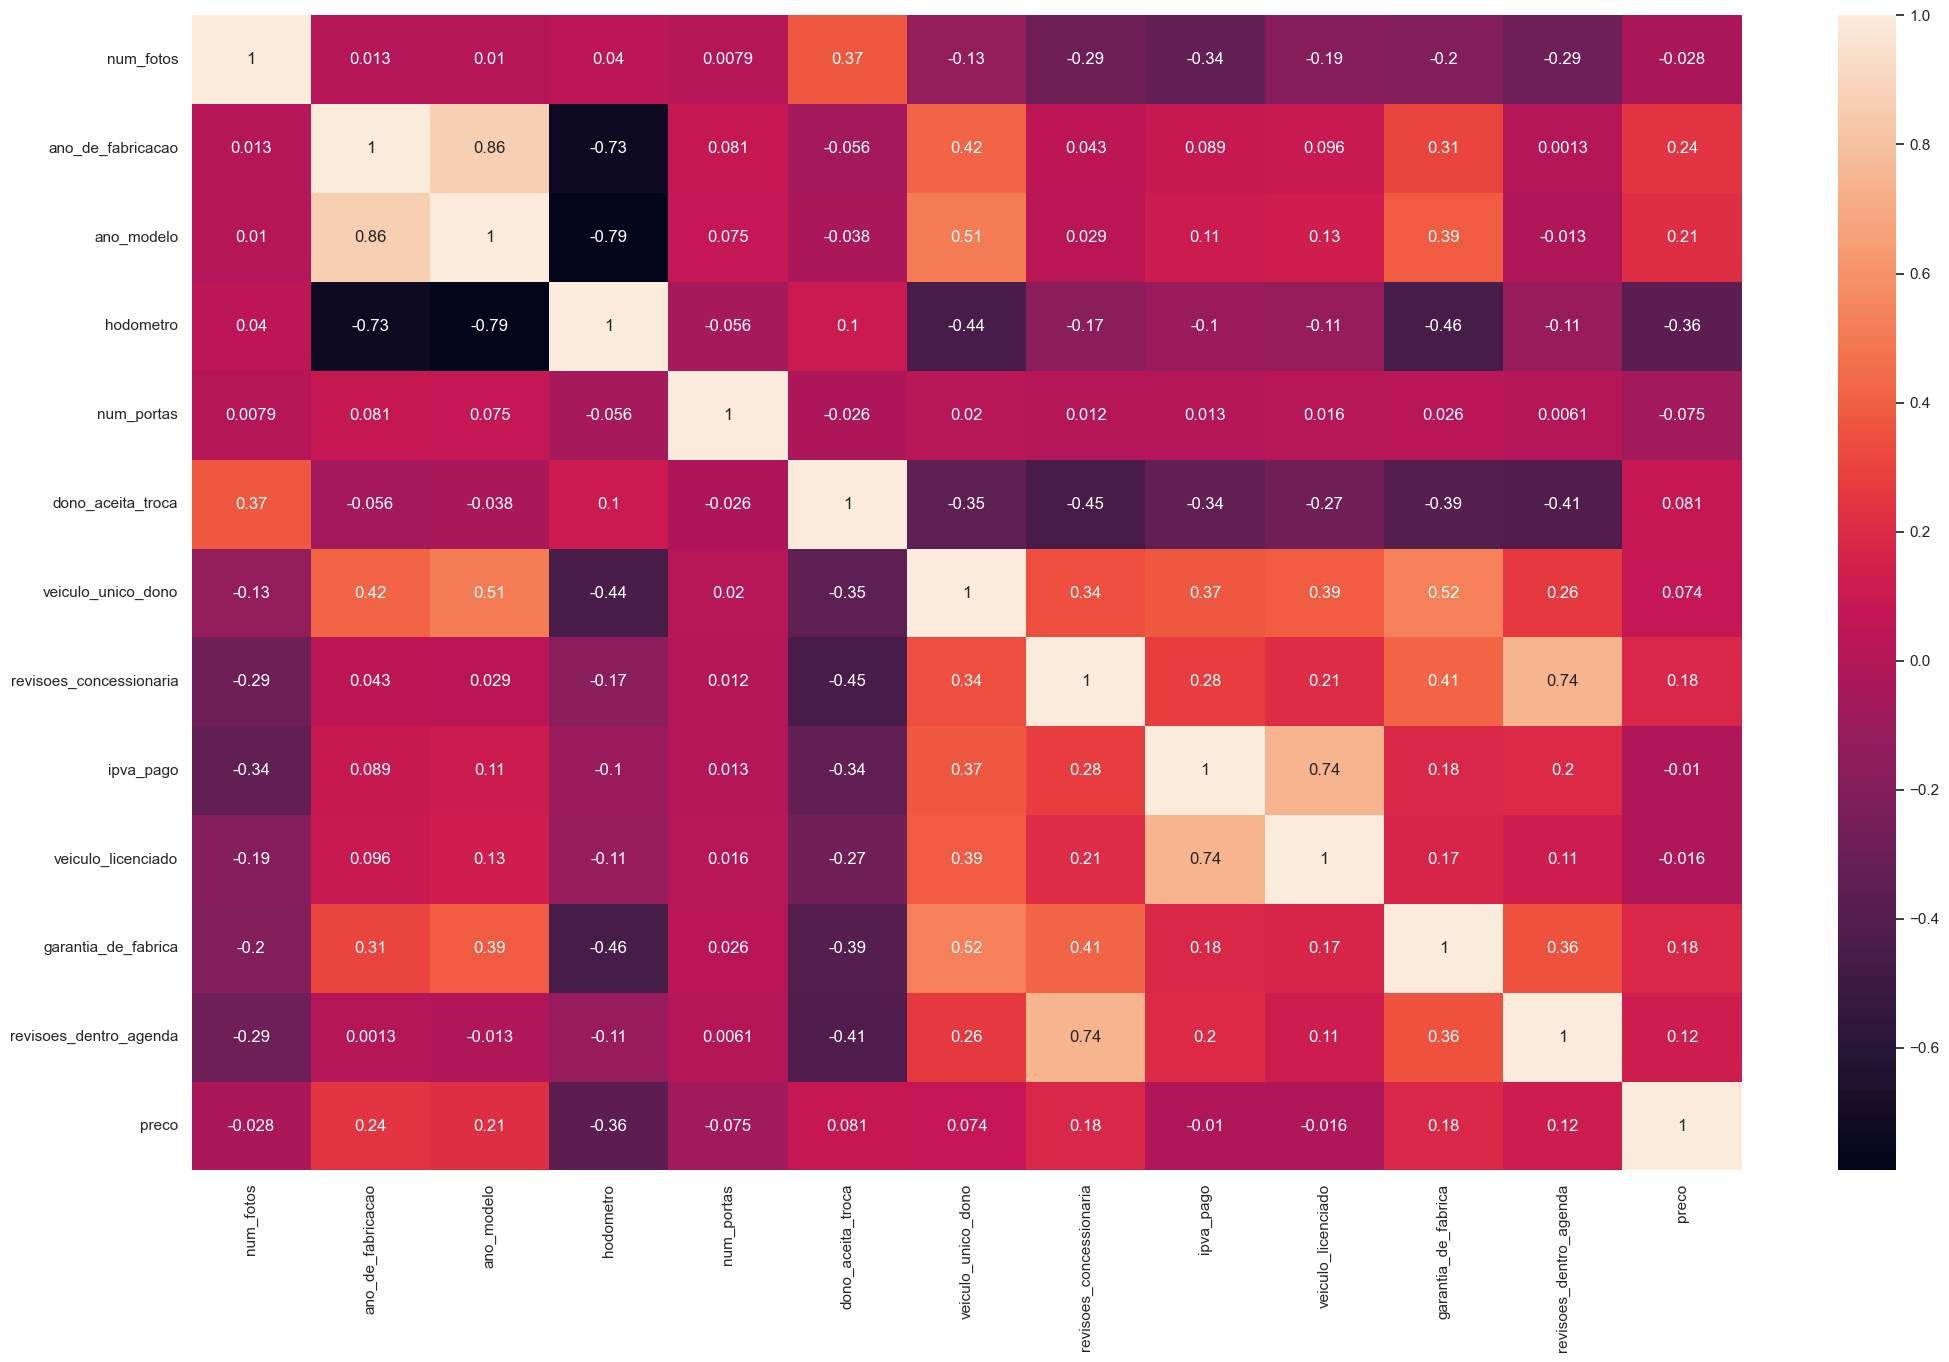

In [50]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True );